Notebook to test oversampling techniques in scRNA-seq data

In [1]:
import os
os.chdir('../')
import logging
import numpy as np
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
# automatically reload source files
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
# load meta-set
metaset_path = '/home/xlv0877/proj_home/dl/data/test/100/mixscale/mixscale_filtered.h5ad'
adata = sc.read(metaset_path)

2025-04-11 16:44:59,712 - INFO - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-04-11 16:44:59,713 - INFO - NumExpr defaulting to 8 threads.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated.

In [6]:
# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42
model_dir = 'models/mixscale'
# define all labels to classify on
cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# create classification label
adata.obs['cls_label'] = adata.obs[cls_labels].agg(';'.join, axis=1)
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# add status label (control or perturbed)
adata.obs['status'] = 'perturbed'
adata.obs.loc[adata.obs['perturbation'] == 'control', 'status'] = 'ctrl'
# remove perturbations with less than minimum amount of cells
min_cells = 50
p_summary = adata.obs.cls_label.value_counts()
valid_perturbations = p_summary[p_summary >= min_cells].index
adata = adata[adata.obs.cls_label.isin(valid_perturbations)].copy()

In [7]:
# before initial training, split the entire dataset into test and train
from sklearn.model_selection import train_test_split

# Split features (X) and labels (y)
X = adata.X  # Feature matrix (can be sparse)
y = adata.obs[cls_label]  # Class labels

# Perform stratified train-test split
train_idx, test_idx = train_test_split(
    range(adata.n_obs),
    test_size=0.1,
    stratify=y,           # Preserve class distribution
    random_state=seed
)
adata.obs['initial_split'] = ''
adata.obs.iloc[train_idx, np.where(adata.obs.columns == 'initial_split')[0]] = 'train'
adata.obs.iloc[test_idx, np.where(adata.obs.columns == 'initial_split')[0]] = 'test'
# split the data before we start upsampling
train_set = adata[train_idx].copy()
raw_test_set = adata[test_idx].copy()

In [8]:
logging.info('pca')
sc.pp.pca(adata)
logging.info('neighbors')
sc.pp.neighbors(adata)
logging.info('umap')
sc.tl.umap(adata)

2025-04-11 16:52:57,764 - INFO - pca
2025-04-11 16:54:50,359 - INFO - neighbors
2025-04-11 16:55:30.750553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 16:55:32.006261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 16:56:06,301 - INFO - umap


... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'initial_split' as categorical


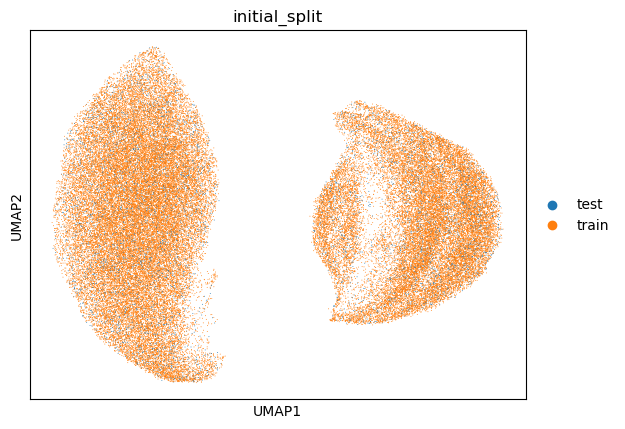

In [9]:
sc.pl.umap(adata, color='initial_split')

In [31]:
# check split for a good class
good_class = 'retinal pigment epithelial cells;CRISPRi;ZMAT2'
ctrl_class = 'retinal pigment epithelial cells;CRISPRi;control'
gcd = adata[(adata.obs.cls_label==good_class)].copy()

In [35]:
logging.info('pca')
sc.pp.pca(gcd)
logging.info('neighbors')
sc.pp.neighbors(gcd)
logging.info('umap')
sc.tl.umap(gcd)

2025-04-11 17:35:07,941 - INFO - pca
2025-04-11 17:35:08,636 - INFO - neighbors
2025-04-11 17:35:08,736 - INFO - umap


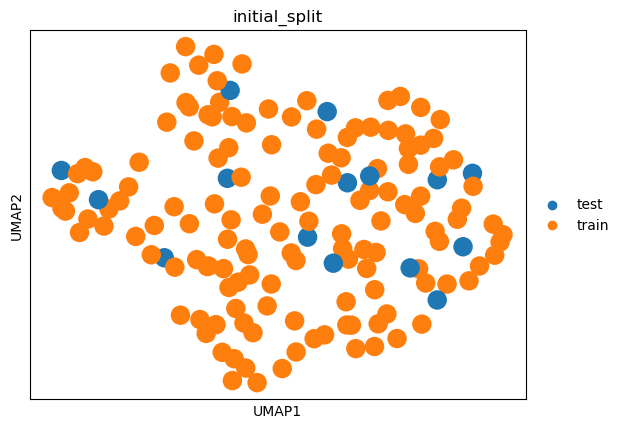

In [36]:
sc.pl.umap(gcd, color=['initial_split'], wspace=0.25)

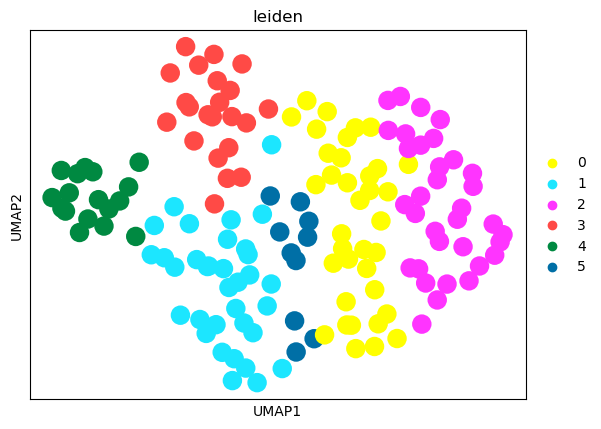

In [38]:
sc.tl.leiden(gcd)
sc.pl.umap(gcd, color=['leiden'], wspace=0.25)

In [70]:
from src.sampling import draw_samples

upsampled_all = draw_samples(gcd, n_samples=int(gcd.n_obs*2), max_sampling_rate=0.5)

Processing condition: 100%|██████████| 1/1 [00:00<00:00,  5.47condition/s]


Collapsing list to uniform dataset


In [71]:
# Filter for upsampled only
import scipy.sparse as sp
upsampled_all.X = sp.csr_matrix(upsampled_all.X)
upsampled = upsampled_all[upsampled_all.obs['upsampled'],:].copy()

In [72]:
logging.info('pca')
sc.pp.pca(upsampled_all)
logging.info('neighbors')
sc.pp.neighbors(upsampled_all)
logging.info('umap')
sc.tl.umap(upsampled_all)

2025-04-11 17:57:26,095 - INFO - pca
2025-04-11 17:57:27,338 - INFO - neighbors
2025-04-11 17:57:27,439 - INFO - umap


<Axes: ylabel='Count'>

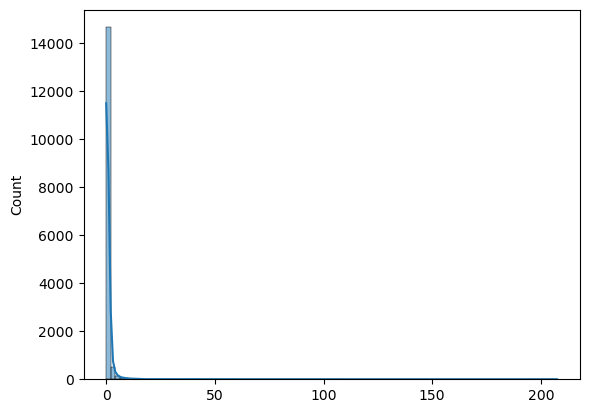

In [63]:
import seaborn as sns
sns.histplot(gcd.X.mean(axis=0).A1, bins=100, kde=True)

<Axes: ylabel='Count'>

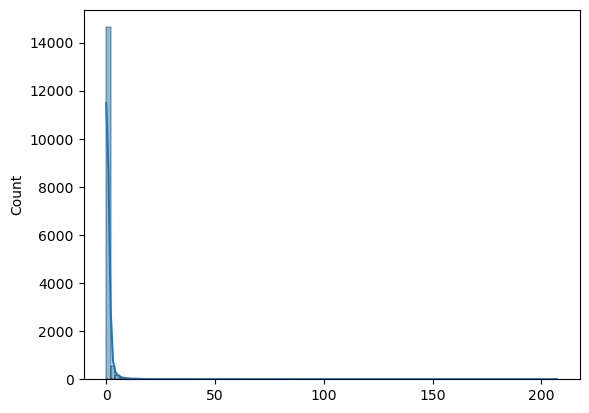

In [73]:
sns.histplot(upsampled.X.mean(axis=0).A1, bins=100, kde=True)

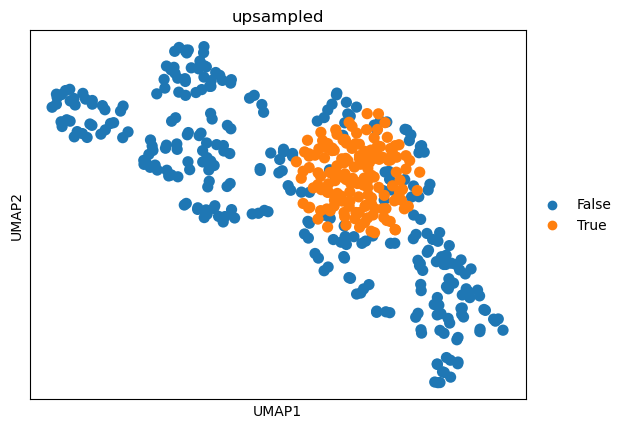

In [75]:
sc.pl.umap(upsampled_all, color=['upsampled'], wspace=0.25)

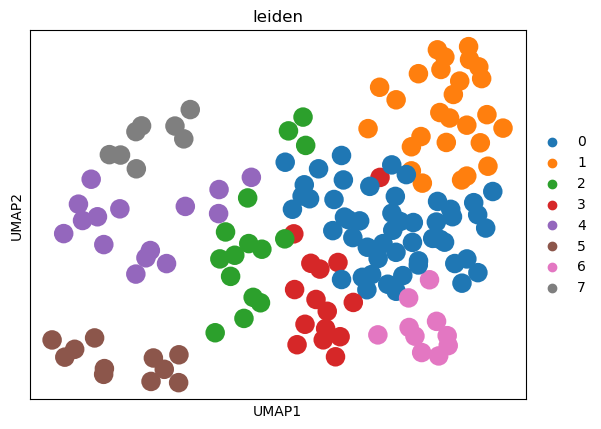

In [69]:
sc.tl.leiden(upsampled)
sc.pl.umap(upsampled, color=['leiden'], wspace=0.25)

In [ ]:
# what is the noise

In [ ]:
# define label in .obs to classify
cls_label = 'exact_perturbation'
# filter for lower mitochondrial percentage of 0.1 (cancer cell lines tend to have higher though..)
# remove control samples as they introduce a very noisy class for cancer samples
n_tot = adata.n_obs
mito_mask = (adata.obs['percent_mito'] < 0.1)
ctrl_mask = (adata.obs['perturbation']!='control')
adata = adata[ctrl_mask].copy()
# Focus on the first 5 perturbations
idx = np.where(adata.obs.perturbation.isin(adata.obs.perturbation.value_counts()[:5].index))
adata = adata[idx].copy()

In [ ]:
# remove non-expressed genes
sc.pp.filter_genes(adata, min_cells=1)

In [ ]:
# Set a global seed for reproducability
seed = 42

In [ ]:
# before initial training, split the entire dataset into test and train
from sklearn.model_selection import train_test_split

# Split features (X) and labels (y)
X = adata.X  # Feature matrix (can be sparse)
y = adata.obs[cls_label]  # Class labels

# Perform stratified train-test split
train_idx, test_idx = train_test_split(
    range(adata.n_obs),
    test_size=0.1,
    stratify=y,           # Preserve class distribution
    random_state=seed
)
adata.obs['initial_split'] = None
adata.obs.iloc[train_idx, (adata.obs.shape[1]-1)] = 'train'
adata.obs.iloc[test_idx, (adata.obs.shape[1]-1)] = 'test'
# split the data before we start upsampling
train_set = adata[train_idx].copy()
test_set = adata[test_idx].copy()

Draw equal amount of cells and introduce oversampling with random noise

In [ ]:
from src.sampling import get_zero_inflation_rate
# check zero inflation before sampling
zi = get_zero_inflation_rate(train_set)
zi

In [ ]:
from src.sampling import draw_samples

n_samples = 2_000
n_perts_per_cell_type = 2
n_control = n_samples * n_perts_per_cell_type
# draw equal samples from each class
subset = draw_samples(train_set,
                      label=cls_label,
                      n_samples=n_samples,
                      n_control=n_control,
                      seed=seed)
# check zero-inflation of data and how it compares after added noise
get_zero_inflation_rate(subset)

## Test an individual class

In [ ]:
# get source data
target = adata.obs[cls_label].value_counts().index[0]
tmp = adata[adata.obs[cls_label]==target].copy()
sc.pp.pca(tmp)
sc.pp.neighbors(tmp)
sc.tl.umap(tmp)
sc.pl.umap(tmp, color='initial_split')

In [ ]:
# check ncounts in source data
sc.pl.umap(tmp[tmp.obs['initial_split']=='train'], color='ncounts')

In [ ]:
# compare to up-sampled data
tmp_gen = subset[subset.obs[cls_label]==target].copy()
sc.pp.pca(tmp_gen)
sc.pp.neighbors(tmp_gen)
sc.tl.umap(tmp_gen)

In [ ]:
# check how many are upsampled
tmp_gen.obs['upsampled'].value_counts()

In [ ]:
# check ncounts
sc.pl.umap(tmp_gen, color='ncounts')

In [ ]:
# check difference between original and up-sampled data
sc.pl.umap(tmp_gen, color='upsampled')